# Training Results Analysis

Run this notebook after training completes to analyze model performance, metrics, and generate visualizations.

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import h5py
import yaml
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Checkpoint and Model

In [2]:
# Find latest checkpoint directory
checkpoint_dirs = sorted(glob.glob("./checkpoints/train*"))

if checkpoint_dirs:
    latest_ckpt = checkpoint_dirs[-1]
    print(f"✅ Found checkpoint: {latest_ckpt}")
    
    # List files in checkpoint
    ckpt_files = os.listdir(latest_ckpt)
    print(f"Files in checkpoint:")
    for f in ckpt_files:
        print(f"  - {f}")
else:
    print("❌ No checkpoints found. Train the model first.")
    raise FileNotFoundError("No checkpoints in ./checkpoints/")

✅ Found checkpoint: ./checkpoints\train5
Files in checkpoint:
  - best_model.pt
  - last_model.pt


## 2. Load Dataset and Data Loaders

In [3]:
# Import dataset building function from main notebook
import sys
sys.path.insert(0, './')

# Find dataset file
dataset_files = sorted(glob.glob("../outputs/logmels_*.h5"))

if dataset_files:
    dataset_path = dataset_files[-1]  # Use most recent
    print(f"✅ Using dataset: {dataset_path}")
else:
    raise FileNotFoundError("No dataset files found in ../outputs/")

# Load metadata
def get_yaml_meta(h5_path):
    """Read YAML metadata from HDF5."""
    with h5py.File(h5_path, "r") as f:
        raw = f["/meta/file_description.yaml"][()].decode("utf-8")
    return yaml.safe_load(raw)

meta = get_yaml_meta(dataset_path)
print(f"\nDataset Info:")
if isinstance(meta, dict) and 'preprocessing_config' in meta:
    print(f"  Sample Rate: {meta['preprocessing_config'].get('sr', 'N/A')} Hz")
    print(f"  Mel Bands: {meta['preprocessing_config'].get('n_mels', 'N/A')}")
else:
    # Fallback keys for older datasets
    print(f"  Sample Rate: {meta.get('sr', 'N/A')} Hz")
    print(f"  Mel Bands: {meta.get('n_mels', 'N/A')}")

print(f"  Total Speakers: {meta.get('total_speakers', 'N/A')}")
print(f"  Base Speakers: {meta.get('total_base_speakers', 'N/A')}")
print(f"  VTLP Speakers: {meta.get('total_vtlp_speakers', 'N/A')}")

✅ Using dataset: ../outputs\logmels_volnorm_silrem_19-12-25.h5

Dataset Info:
  Sample Rate: N/A Hz
  Mel Bands: 64
  Total Speakers: N/A
  Base Speakers: N/A
  VTLP Speakers: N/A


In [4]:
# Load split statistics
with h5py.File(dataset_path, "r") as f:
    if "/meta/split_statistics.json" in f:
        stats_raw = f["/meta/split_statistics.json"][()].decode("utf-8")
        split_stats = yaml.safe_load(stats_raw)
        
        print("\nSplit Statistics:")
        for split, stats in split_stats.items():
            print(f"  {split.upper()}:")
            for key, val in stats.items():
                print(f"    {key}: {val}")
    else:
        print("\nSplit statistics not available in dataset")


Split statistics not available in dataset


## 3. TensorBoard Metrics Analysis

In [5]:
# Find TensorBoard logs
log_dirs = sorted(glob.glob("./logs/*"))

if log_dirs:
    latest_log = log_dirs[-1]
    print(f"✅ Found TensorBoard logs: {latest_log}")
    
    # Try to read TensorBoard events
    try:
        from tensorboard.backend.event_processing import event_accumulator
        
        ea = event_accumulator.EventAccumulator(latest_log)
        ea.Reload()
        
        # List available scalar metrics
        print(f"\nAvailable metrics:")
        for tag in ea.Tags()['scalars'][:10]:
            print(f"  - {tag}")
    except ImportError:
        print("⚠️ tensorboard not installed. Install with: pip install tensorboard")
        ea = None
else:
    print("⚠️ No TensorBoard logs found.")
    ea = None

✅ Found TensorBoard logs: ./logs\20260124-022536

Available metrics:


⚠️ Could not load TensorBoard metrics: 'Key train/loss was not found in Reservoir'


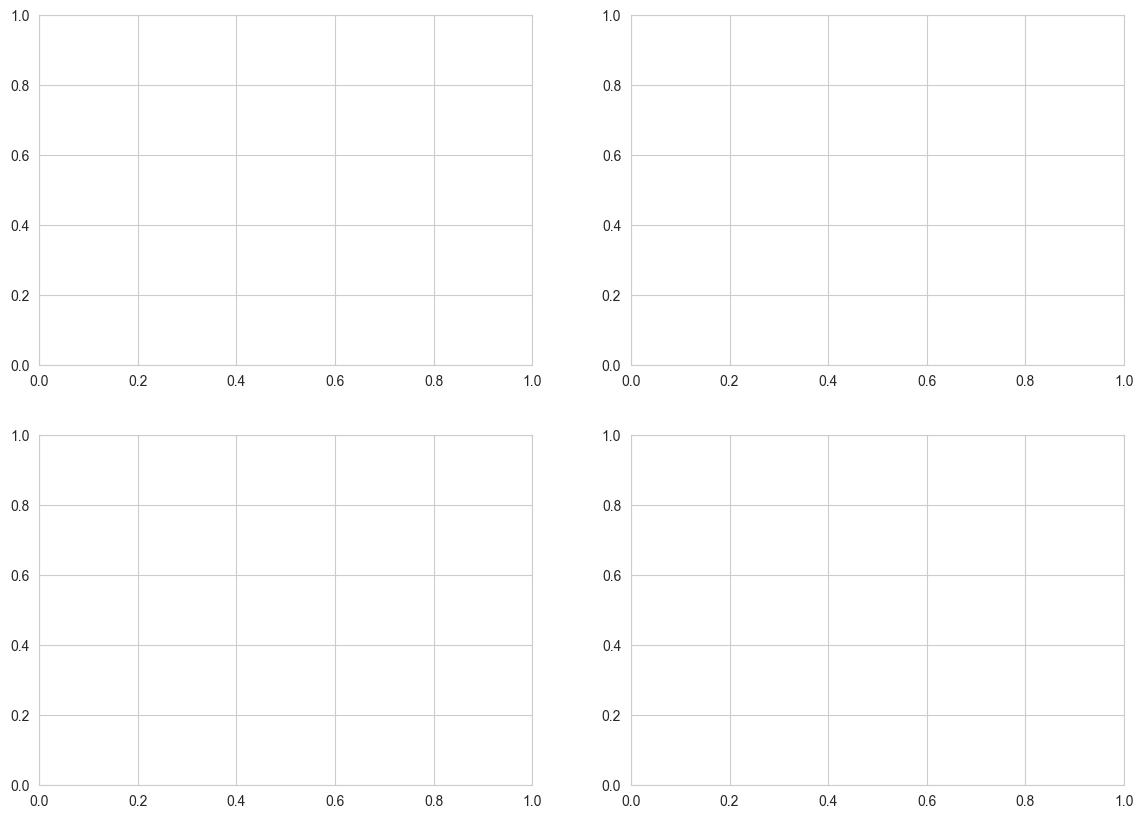

In [6]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract metrics
try:
    train_loss = ea.Scalars('train/loss')
    train_acc = ea.Scalars('train/acc')
    val_loss = ea.Scalars('validate/loss')
    val_acc = ea.Scalars('validate/acc')
    
    # 1. Training vs Validation Loss
    axes[0, 0].plot([s.step for s in train_loss], [s.value for s in train_loss], label='Train', alpha=0.7)
    axes[0, 0].plot([s.step for s in val_loss], [s.value for s in val_loss], label='Val', alpha=0.7)
    axes[0, 0].set_xlabel('Global Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training vs Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Training vs Validation Accuracy
    axes[0, 1].plot([s.step for s in train_acc], [s.value for s in train_acc], label='Train', alpha=0.7)
    axes[0, 1].plot([s.step for s in val_acc], [s.value for s in val_acc], label='Val', alpha=0.7)
    axes[0, 1].set_xlabel('Global Step')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training vs Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Loss convergence (zoomed)
    last_50_train = train_loss[-50:]
    last_50_val = val_loss[-50:]
    axes[1, 0].plot([s.step for s in last_50_train], [s.value for s in last_50_train], label='Train (last 50)', alpha=0.7)
    axes[1, 0].plot([s.step for s in last_50_val], [s.value for s in last_50_val], label='Val (last 50)', alpha=0.7)
    axes[1, 0].set_xlabel('Global Step')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Loss Convergence (Last 50 Steps)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Final metrics summary
    axes[1, 1].axis('off')
    final_train_loss = train_loss[-1].value
    final_val_loss = val_loss[-1].value
    final_train_acc = train_acc[-1].value
    final_val_acc = val_acc[-1].value
    
    summary_text = f"""FINAL METRICS (Last Epoch)
    
Train Loss:  {final_train_loss:.4f}
Val Loss:    {final_val_loss:.4f}

Train Acc:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)
Val Acc:     {final_val_acc:.4f} ({final_val_acc*100:.2f}%)

Total Steps: {train_loss[-1].step}
    """
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                   verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('./training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved training curves to ./training_curves.png")
    
except Exception as e:
    print(f"⚠️ Could not load TensorBoard metrics: {e}")

## 4. Checkpoint Statistics

In [7]:
# Check model sizes
best_model_path = os.path.join(latest_ckpt, "best_model.pt")
last_model_path = os.path.join(latest_ckpt, "last_model.pt")

print("Checkpoint Files:")
for path in [best_model_path, last_model_path]:
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"  {os.path.basename(path)}: {size_mb:.2f} MB")

Checkpoint Files:
  best_model.pt: 13.94 MB
  last_model.pt: 13.94 MB


## 5. Summary Report

In [8]:
# Generate summary report with robust metadata handling
# Fallbacks for missing variables
try:
    split_stats
except NameError:
    split_stats = {}

sr = (
    meta.get('preprocessing_config', {}).get('sr')
    if isinstance(meta, dict) else None
)
sr = sr if sr is not None else meta.get('sr', 'N/A')

n_mels = (
    meta.get('preprocessing_config', {}).get('n_mels')
    if isinstance(meta, dict) else None
)
n_mels = n_mels if n_mels is not None else meta.get('n_mels', 'N/A')

total_speakers = meta.get('total_speakers', 'N/A')
base_speakers = meta.get('total_base_speakers', 'N/A')
vtlp_speakers = meta.get('total_vtlp_speakers', 'N/A')

log_info = latest_log if 'latest_log' in locals() else 'Not found'

report = f"""\n{'='*70}
TRAINING ANALYSIS SUMMARY
{'='*70}

DATASET INFORMATION:
  Path: {dataset_path}
  Sample Rate: {sr} Hz
  Mel Bands: {n_mels}
  Total Speakers: {total_speakers}
  Base Speakers: {base_speakers}
  VTLP Speakers: {vtlp_speakers}
  
SPLIT DISTRIBUTION:
  Train: {split_stats.get('train', {}).get('num_samples', 'N/A')} samples
  Val:   {split_stats.get('val', {}).get('num_samples', 'N/A')} samples  
  Test:  {split_stats.get('test', {}).get('num_samples', 'N/A')} samples

CHECKPOINT:
  Location: {latest_ckpt}
  Best Model: {os.path.basename(best_model_path)} ({os.path.getsize(best_model_path)/(1024*1024):.2f} MB)
  Last Model: {os.path.basename(last_model_path)} ({os.path.getsize(last_model_path)/(1024*1024):.2f} MB)

TensorBoard Logs:
  {log_info}

{'='*70}

NEXT STEPS:
1. Run cell 3 to view TensorBoard metrics and training curves
2. Run additional analysis cells for detailed evaluation
3. Use best_model.pt for inference

{'='*70}\n"""

print(report)

# Save report
with open('./analysis_report.txt', 'w') as f:
    f.write(report)
print("✅ Report saved to ./analysis_report.txt")


TRAINING ANALYSIS SUMMARY

DATASET INFORMATION:
  Path: ../outputs\logmels_volnorm_silrem_19-12-25.h5
  Sample Rate: N/A Hz
  Mel Bands: 64
  Total Speakers: N/A
  Base Speakers: N/A
  VTLP Speakers: N/A

SPLIT DISTRIBUTION:
  Train: N/A samples
  Val:   N/A samples  
  Test:  N/A samples

CHECKPOINT:
  Location: ./checkpoints\train5
  Best Model: best_model.pt (13.94 MB)
  Last Model: last_model.pt (13.94 MB)

TensorBoard Logs:
  ./logs\20260124-022536


NEXT STEPS:
1. Run cell 3 to view TensorBoard metrics and training curves
2. Run additional analysis cells for detailed evaluation
3. Use best_model.pt for inference


✅ Report saved to ./analysis_report.txt


## 6. Model Inference Verification (Optional)

In [9]:
# Optional: Load and verify model works
print("To perform full test set evaluation:")
print("1. Import model classes from main notebook")
print("2. Load best_model.pt")
print("3. Run inference on test set")
print("4. Generate confusion matrix and per-speaker accuracy")
print("\nThis requires importing the Backbone and SpeakerClassifier classes.")
print("See the main voice_recognition_rnn_cnn.ipynb for full evaluation code.")

To perform full test set evaluation:
1. Import model classes from main notebook
2. Load best_model.pt
3. Run inference on test set
4. Generate confusion matrix and per-speaker accuracy

This requires importing the Backbone and SpeakerClassifier classes.
See the main voice_recognition_rnn_cnn.ipynb for full evaluation code.
